In [2]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_rv_from_yahoo, get_rv_from_data, get_tickers_in_data, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare the prediction accuracy of two different models
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [3]:
print(get_tickers_in_data())

['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI', '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20', '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC', '.SSMI', '.STI', '.STOXX50E']


Total of 5530 found for symbol: .SPX
Total training observations: 5208
Total validation observations: 300


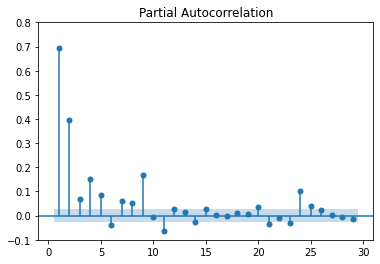

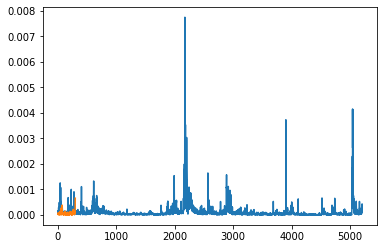

In [17]:
# fetch data through yahoo finance API, compute features, split into training and validation subsets
# ... for both NN and HAR

ticker = ".SPX"

# data = get_rv_from_yahoo(ticker)
# or use ...
data = get_rv_from_data(ticker)
n_observations = len(data)
print(f"Total of {n_observations} found for symbol: {ticker}")

# data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, train_size=.8)
data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, test_size = 300)#300

# data_nn_train.x_t = data_nn_train.x_t[:-200]
# data_nn_train.y_t = data_nn_train.y_t[:-200]

train_observations, test_observations = len(data_nn_train), len(data_nn_val)
print(f"Total training observations: {train_observations}")
print(f"Total validation observations: {test_observations}")

# to determine gap used in TimeSeriesSplit
plot_pacf(data_har_train.y, lags = range(1, 30))
plt.ylim(-0.1, 0.8)
plt.show()
plt.plot(data_har_train.y)
plt.plot(data_har_val.y)
plt.show()

epoch 1 - training loss: 0.19365867657762115 - testing loss: 0.1721477061510086
epoch 2 - training loss: 0.15292049189332352 - testing loss: 0.13479162752628326
epoch 3 - training loss: 0.11864851259281448 - testing loss: 0.10347292572259903
epoch 4 - training loss: 0.0900464349224334 - testing loss: 0.07748115807771683
epoch 5 - training loss: 0.0664719942377991 - testing loss: 0.05623425915837288
epoch 6 - training loss: 0.04738839506216333 - testing loss: 0.03923439234495163
epoch 7 - training loss: 0.0323239224971828 - testing loss: 0.026030100882053375
epoch 8 - training loss: 0.02083625333051192 - testing loss: 0.01618320122361183
epoch 9 - training loss: 0.012481717737802732 - testing loss: 0.00924020167440176
epoch 10 - training loss: 0.006789760625672718 - testing loss: 0.004711001645773649
epoch 11 - training loss: 0.003248056137644741 - testing loss: 0.002061630832031369
epoch 12 - training loss: 0.0013069796240522086 - testing loss: 0.0007330315420404077
epoch 13 - training

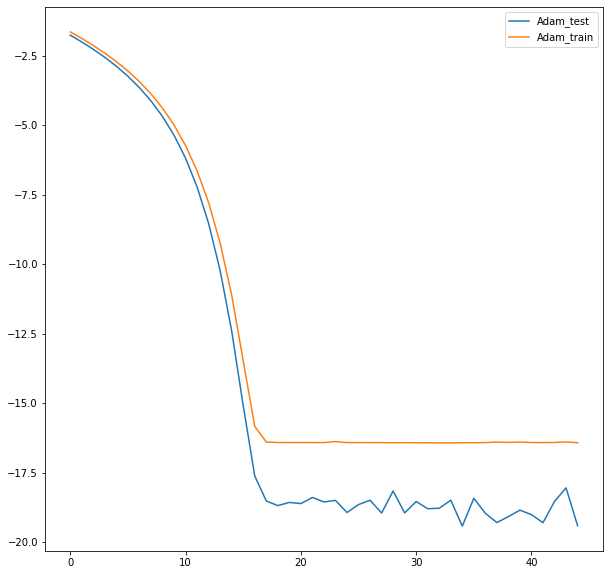

3.7695576e-09


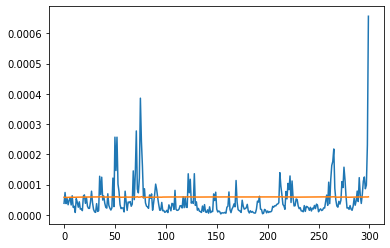

In [23]:
def with_variable_optimizer(model, optimizer: optim.Optimizer, ax, name: str, lr = .0005, verbose = 0):

    trainloader = torch.utils.data.DataLoader(data_nn_train, batch_size = 10, shuffle=True)
    testloader = torch.utils.data.DataLoader(data_nn_val, batch_size = 10, shuffle=True)

    optimizer_inst = optimizer(model.parameters(), lr=lr)
    if isinstance(optimizer, optim.Adam):
        optimizer_inst = optimizer(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    earlystopper = EarlyStopper(10, 0)

    results = {
        "test_loss": [],
        "train_loss": [],
    }

    for epoch in range(1, int(1e4)):
        
        train_running_loss = []
        for batch in trainloader:
            
            # each batch contains one set of features and one set of targets
            batch_features: torch.Tensor = batch[0]
            batch_targets: torch.Tensor = batch[1]
        
            # reset gradient optimizer
            optimizer_inst.zero_grad()
            
            # with the batch features, predict the batch targets
            output = model(batch_features)
            
            # compute the loss and .backward() computes the gradient of the loss function
            loss = criterion(output, batch_targets)
            loss.backward()
            
            # update parameters (something like: params += -learning_rate * gradient)
            optimizer_inst.step()
            
            # keep track of loss to log improvements of the fit
            train_running_loss.append(loss.item())

        # the in-sampe loss after performing one epoch; the criterion function averaged for each batch
        train_running_loss = np.average(train_running_loss)
        
        # if testdata is also provided, compute the out-of-sample performance of the model
        if testloader:
            with torch.no_grad():
                
                test_output = model(data_nn_val.x_t)
                resid = data_nn_val.y_t.detach().numpy().reshape(-1) - test_output.detach().numpy().reshape(-1)
                test_running_loss = np.average(resid**2)
                # test_running_loss = criterion(test_output, data_nn_val.y_t)
                
                if verbose > 0:
                    print(f"epoch {epoch} - training loss: {train_running_loss} - testing loss: {test_running_loss}")

                results["test_loss"].append(test_running_loss)
                results["train_loss"].append(train_running_loss)
                
                # if an early stopper is provided, check if validation loss is still improving
                # if not, stop the estimation
                if earlystopper:
                    if earlystopper.early_stop(test_running_loss):
                        break
                    
    # after all epochs, compute in-sample loss as well
    train_output = model(data_nn_train.x_t)
    resid = data_nn_train.y_t.detach().numpy().reshape(-1) - train_output.detach().numpy().reshape(-1)
    training_running_loss = np.average(resid**2)
    
    if ax:
        ax.plot(np.log(results["test_loss"]), label = f"{name}_test")
        ax.plot(np.log(results["train_loss"]), label = f"{name}_train")
        ax.legend()
        
    return training_running_loss, test_running_loss
   
lr = 5e-5
fig, axs = plt.subplots(1,1, figsize = (10,10)) 
verbose =1 
model = ForwardNeuralNetwork(3, 1, [2,])
loss = with_variable_optimizer(model, optim.Adam, ax = axs, name = "Adam", lr = lr, verbose = verbose)
print(loss)
# model = ForwardNeuralNetwork(3, 1, [2,])
# loss = with_variable_optimizer(model, optim.SGD, ax = axs, name = "SGD", lr = lr, verbose = verbose)
# print(loss)
plt.show()

output = model(data_nn_val.x_t).detach().numpy().reshape(-1,).copy()
true = data_nn_val.y_t.detach().numpy().reshape(-1,).copy()
resid = output - true
print(np.average(resid**2))
plt.plot(data_nn_val.y_t.detach().numpy().reshape(-1,))
plt.plot(output)
plt.show()

In [24]:
lr = 1e-3
# lr = .01

i = 0
lowest = float("inf")
lowest_test = float("inf")
while True:
    i += 1
    
    model = ForwardNeuralNetwork(3, 1, [2,])
    training_loss, test_loss = with_variable_optimizer(model, optim.Adam, ax = None, name = "Adam", lr = lr)
    
    if training_loss < lowest:
        lowest = training_loss
        
        # plot predictions
        fig, axs = plt.subplots(2, 1, figsize=(10,10))
        
        # plot in-sample
        output = model(data_nn_val.x_t).detach().numpy().reshape(-1,).copy()
        axs[0].plot(data_nn_val.y_t.detach().numpy().reshape(-1,))
        axs[0].plot(output)
        axs[0].set_title("test prediction vs true realized vol.")
        
        # plot out-of-sample
        output = model(data_nn_train.x_t).detach().numpy().reshape(-1,).copy()
        axs[1].plot(data_nn_train.y_t.detach().numpy().reshape(-1,))
        axs[1].plot(output)
        axs[1].set_title("train prediction vs true realized vol.")
        plt.show()
        
    if test_loss < lowest_test:
        lowest_test = test_loss
        
    print(f"current training loss: {training_loss} - lowest training loss: {lowest}")
    print(f"current testing loss: {test_loss} - lowest testing loss: {lowest_test}")

KeyboardInterrupt: 